In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model
#from tensorflow.keras.preprocessing import image
import cv2
import util

In [129]:
train_df = pd.read_csv("train-small.csv")
valid_df = pd.read_csv("valid-small.csv")

test_df = pd.read_csv("test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [130]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [131]:
train_df[labels] = train_df[labels].astype('float32')
valid_df[labels] = valid_df[labels].astype('float32')
test_df[labels] = test_df[labels].astype('float32')
train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8270,0.0,0.0,0.0
1,00029855_001.png,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,29855,0.0,0.0,0.0
2,00001297_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1297,1.0,0.0,0.0
3,00012359_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12359,0.0,0.0,0.0
4,00017951_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,17951,0.0,0.0,0.0


In [132]:
# Checking for Data Leakage
def check_for_leakage(df1, df2, patient_col):
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0
    
    return leakage

In [133]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [134]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
     
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [135]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [136]:
IMAGE_DIR = "nih/images-small/images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 221 validated image filenames.
getting train and valid generators...
Found 221 validated image filenames.


C:\Users\immah\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 779 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Found 49 validated image filenames.
Found 87 validated image filenames.


C:\Users\immah\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 151 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\immah\anaconda3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 333 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


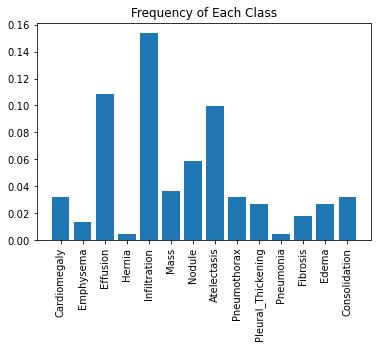

In [137]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [138]:
def compute_class_freqs(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [139]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.03167421, 0.01357466, 0.10859729, 0.00452489, 0.15384616,
       0.0361991 , 0.05882353, 0.09954751, 0.03167421, 0.02714932,
       0.00452489, 0.01809955, 0.02714932, 0.03167421], dtype=float32)

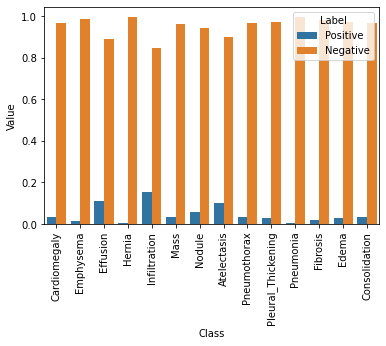

In [140]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [141]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

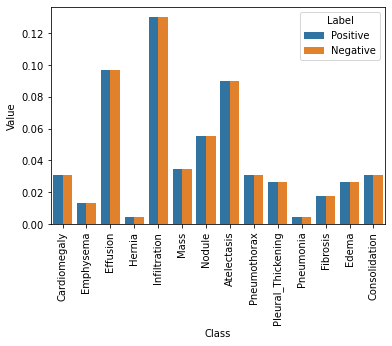

In [142]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [143]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
   
    def weighted_loss(y_true, y_pred):
    
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [144]:
# create the base pre-trained model
base_model = DenseNet121(weights='./nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

<a name='4'></a>
## 4 Training [optional]

**Note** that we have already provided a pre-trained model, so you don't need to run the following training cell (as it will take some time).

With our model ready for training, we will use the `model.fit()` function in Keras to train our model. 
- We are training on a small subset of the dataset (~1%).  


In [145]:
# """
# OPTIONAL: uncomment this code to practice training the model.
# This is optional because we have loaded pre-trained weights after this.
# """

# history = model.fit_generator(train_generator, 
#                               validation_data=valid_generator,
#                               steps_per_epoch=100, 
#                               validation_steps=25, 
#                               epochs = 3)

# plt.plot(history.history['loss'])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("Training Loss Curve")
# plt.show()

In [146]:
model.load_weights("./nih/pretrained_model.h5")

In [147]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

C:\Users\immah\AppData\Local\Temp/ipykernel_20124/2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


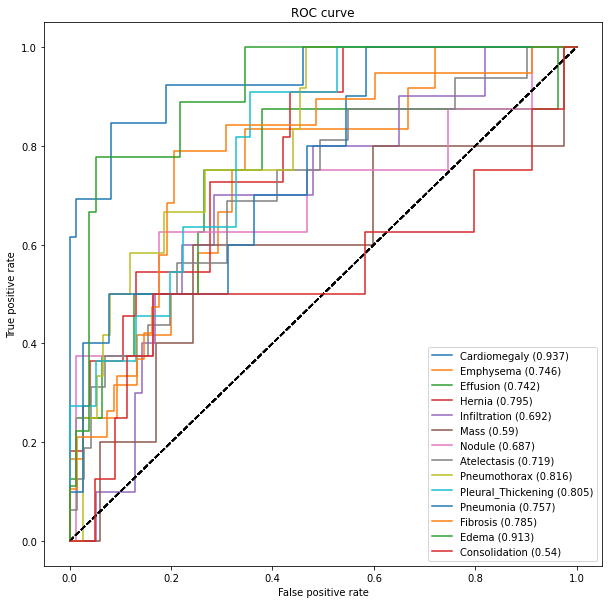

In [148]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">


In [149]:
df = pd.read_csv("train-small.csv")
IMAGE_DIR = "nih/images-small/images/"

#only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [150]:
labels_to_show

array(['Cardiomegaly', 'Edema', 'Pneumothorax', 'Pleural_Thickening'],
      dtype='<U18')

In [151]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

In [152]:
def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

In [153]:
preprocessed_input = load_image('00000154_000.png', IMAGE_DIR, df)

In [154]:
predictions = model.predict(preprocessed_input)

1/1 [==============================] - 3s 3s/step


In [155]:
import tensorflow as tf


In [156]:
def compute_gradcam(model, img, image_dir, df, labels, selected_labels, layer_name='bn',
                   W = 320, H=320):
    
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    
    ##############################
    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')
    ##############################
    
    
    layer_name='bn'
    conv_output = model.get_layer(layer_name).output
    gradModel = Model(
                inputs=[model.inputs],
                outputs=[conv_output,model.output])
    
    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")

            cls = 0 # specific class output probability
            with tf.GradientTape() as tape:
                (convOutputs, pred) = gradModel(preprocessed_input)
                loss = pred[:, cls]
            # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)
            
            output, grads_val = convOutputs[0, :], grads[0, :, :, :] #no need of batch information

            weights = np.mean(grads_val, axis=(0, 1))
            cam = np.dot(output, weights)

            # Process CAM
            cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
            cam = np.maximum(cam, 0)
            gradcam = cam / cam.max()
            
            ###############################
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),cmap='gray')
            
            #value = np.array(min(0.5, predictions[0][i])).reshape(1,1)
            value = min(0.5, predictions[0][i])
            value = np.repeat(value,W*H).reshape(W,H)
            plt.imshow(gradcam, cmap='jet', alpha=value)
            j += 1
            #################################

1/1 [==============================] - 0s 231ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Edema


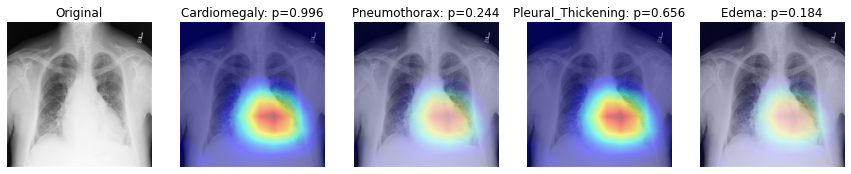

In [157]:
compute_gradcam(model, '00000001_002.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 [==============================] - 0s 232ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Edema


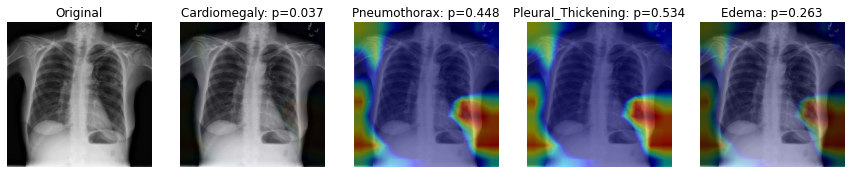

In [158]:
compute_gradcam(model, '00000005_006.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 [==============================] - 0s 236ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Edema


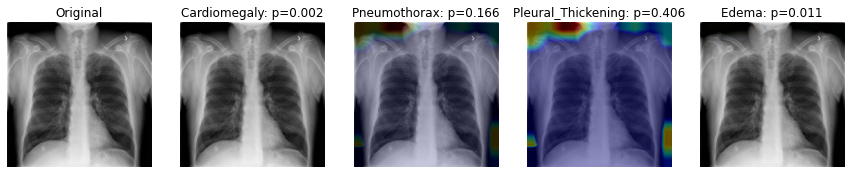

In [159]:
compute_gradcam(model, '00000164_000.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 [==============================] - 0s 236ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Pneumothorax
Generating gradcam for class Pleural_Thickening
Generating gradcam for class Edema


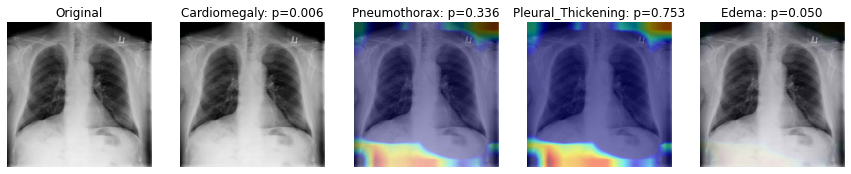

In [160]:
compute_gradcam(model, '00000165_004.png', IMAGE_DIR, df, labels, labels_to_show)